In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'ENPM809K/Assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/ENPM809K/Assignments/assignment1/cs231n/datasets
/content/drive/My Drive/ENPM809K/Assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.350289
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ At the beginning all the weights are really small and can be assumed as zero. This makes all the scores to zero. And since each class makes upto 10% of the dataset, the probability of choosing an image and predicting it would be of a particular class would be 0.1. Hence, loss close to -log(0.1)



In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.023740 analytic: 0.023740, relative error: 7.426555e-07
numerical: -0.729025 analytic: -0.729025, relative error: 2.045177e-08
numerical: -2.288217 analytic: -2.288217, relative error: 2.696022e-08
numerical: 1.788377 analytic: 1.788377, relative error: 9.209871e-09
numerical: 0.401405 analytic: 0.401405, relative error: 2.316821e-07
numerical: -2.034935 analytic: -2.034935, relative error: 1.654710e-08
numerical: 2.069318 analytic: 2.069318, relative error: 1.023562e-08
numerical: -0.143941 analytic: -0.143941, relative error: 2.880922e-07
numerical: -1.793882 analytic: -1.793882, relative error: 2.104597e-08
numerical: -2.138923 analytic: -2.138923, relative error: 1.665470e-08
numerical: -0.819290 analytic: -0.819290, relative error: 1.204983e-08
numerical: 0.119463 analytic: 0.119463, relative error: 2.286152e-07
numerical: 0.370427 analytic: 0.370427, relative error: 1.403869e-07
numerical: 1.539087 analytic: 1.539087, relative error: 5.639427e-08
numerical: -1.686440

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.350289e+00 computed in 0.100746s
vectorized loss: 2.350289e+00 computed in 0.015441s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7 , 1e-6 ,1.5e-7]
regularization_strengths = [2.5e4, 5e4 , 7e3 , 3.5e4]
# learning_rates = [1e-7, 5e-7 ]
# regularization_strengths = [2.5e4, 5e4]                  
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Storing all possible combinations of learning rates and regularization constants
possible_combs = []
for i in learning_rates:
  for j in regularization_strengths:
    possible_combs.append((i,j))


for l_rate, r_strength in possible_combs:
    # Initialize Softmax object
    soft_new = Softmax()
    # training and predicting for the current choice of l_rate and r_strength on
    # the training set
    train_loss = soft_new.train(X_train, y_train, learning_rate= l_rate , reg= r_strength,
                      num_iters=1500, verbose=False)
    y_train_pred = soft_new.predict(X_train)

    #Getting training data acc and applying model to validation data and storing
    # its accuracy
    train_accuracy = np.mean(y_train_pred == y_train)

    y_val_pred = soft_new.predict(X_val)

    val_accuracy = np.mean(y_val_pred == y_val)

    #Storing the results and selecting the object with best validation accuracy
    results[(l_rate , r_strength)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_softmax = soft_new


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 7.000000e+03 train accuracy: 0.348102 val accuracy: 0.361000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.331837 val accuracy: 0.344000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.319061 val accuracy: 0.325000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.313939 val accuracy: 0.328000
lr 1.500000e-07 reg 7.000000e+03 train accuracy: 0.362837 val accuracy: 0.376000
lr 1.500000e-07 reg 2.500000e+04 train accuracy: 0.324224 val accuracy: 0.343000
lr 1.500000e-07 reg 3.500000e+04 train accuracy: 0.324469 val accuracy: 0.339000
lr 1.500000e-07 reg 5.000000e+04 train accuracy: 0.299388 val accuracy: 0.319000
lr 5.000000e-07 reg 7.000000e+03 train accuracy: 0.361959 val accuracy: 0.376000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.323531 val accuracy: 0.340000
lr 5.000000e-07 reg 3.500000e+04 train accuracy: 0.325020 val accuracy: 0.334000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.304408 val accuracy: 0.315000
lr 1.000000e-06 reg 7.000000

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.351000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$  
  * SVM loss function only cares whether the correct class score is higher than rest of the classes by delta. For instance, scores = [10,8,5] and $delta$=1. Here 10 is the correct class score. and if another datapoint is added such that scores = [10,8,5,7]. The loss funcion does not change as the data is already outputting correct class.
  * Whereas in Softmax, addition of a datapoint effects the loss function. The model tries to minimise the influence of other class scores, even when the probability of correct class is higher than rest. the softmax problem tries to improve the correct class probability to 1 and others to 0.  



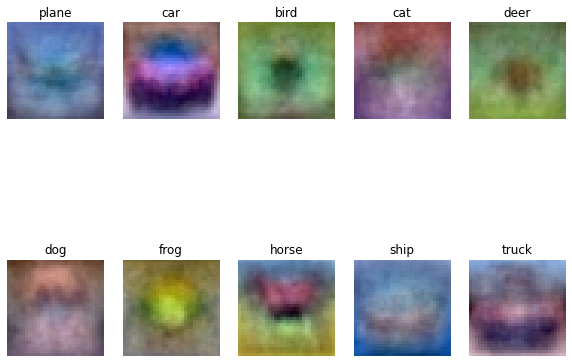

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])